# Modelo de OneClassSVM entrenado con 4F de datos Astro, y predicción sobre datos Unid (no identificados)

**Proyecto**: Detección de posibles fuentes de materia oscura usando ML en datos Fermi-LAT  
**Autor**: Marta Canino Romero  
**Fecha**: febrero-mayo 20225

---

## Descripción:

Este notebook aplica un modelo **One-Class SVM** entrenado con datos de fuentes astrofísicas conocidas (ASTRO) usando las siguientes características:

- E_peak
- beta
- sigma
- betaRel

Este modelo se entrena para identificar anomalías que puedan corresponder a posibles fuentes de materia oscura (UNIDs) en los datos no identificados del catálogo 4FGL.

---

## Objetivos específicos:

- Entrenar modelo OCSVM con [número de features] 
- Optimizar hiperparámetros (grid search sobre `nu` y `gamma`)
- Evaluar sobre datos de validación y prueba
- Aplicar modelo final sobre datos UNID para predicción

---

## Entrada de datos:

- '../data/astro_df.txt`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

from mpl_toolkits.mplot3d import Axes3D

from itertools import combinations

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
data_path = "../data/astro_df.txt"
df_astro = pd.read_csv(data_path, sep='\s+')
print(f" Nombres de las columnas: {list(df_astro.columns)}")

# Renombramos la columna target por claridad
df_astro = df_astro.rename(columns={"astro_DM": "class"})

print(f"Dataset cargado. Forma: {df_astro.shape}")
print(f"Nombres de las columnas: {list(df_astro.columns)}")

display(df_astro.head())


 Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'astro_DM']
Dataset cargado. Forma: (2831, 5)
Nombres de las columnas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)', 'class']


Log(E_peak)  Log(beta)  Log(sigma)  Log(beta_Rel)  class
0    -0.412502  -1.325139    1.356951      -0.122193    0.0
1     0.708140  -0.000174    0.623167      -1.601886    0.0
2     0.224740  -0.581202    1.010041      -0.311249    0.0
3     0.257319  -0.561933    0.615413      -0.038913    0.0
4     0.326110  -1.100179    1.624932      -0.528753    0.0

In [4]:
# Selección de características
features = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
"""Establecemos la columna objetivo aunque al ser un problema de detección de anomalías no la utilizaremos para entrenar el modelo.
Además de que todos los datos están etiquetados como 'astro_DM' = 0.0"""
target = 'class'

print(f"Features seleccionadas: {features}")
print(f"Columna objetivo: {target}")

# Comprobamos valores nulos
print("\n Valores faltantes por columna:")
print(df_astro[features + [target]].isnull().sum())

print("\n Muestra del dataset:")
display(df_astro[features + [target]].head())

Features seleccionadas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
Columna objetivo: class

 Valores faltantes por columna:
Log(E_peak)      0
Log(beta)        0
Log(sigma)       0
Log(beta_Rel)    0
class            0
dtype: int64

 Muestra del dataset:


Log(E_peak)  Log(beta)  Log(sigma)  Log(beta_Rel)  class
0    -0.412502  -1.325139    1.356951      -0.122193    0.0
1     0.708140  -0.000174    0.623167      -1.601886    0.0
2     0.224740  -0.581202    1.010041      -0.311249    0.0
3     0.257319  -0.561933    0.615413      -0.038913    0.0
4     0.326110  -1.100179    1.624932      -0.528753    0.0

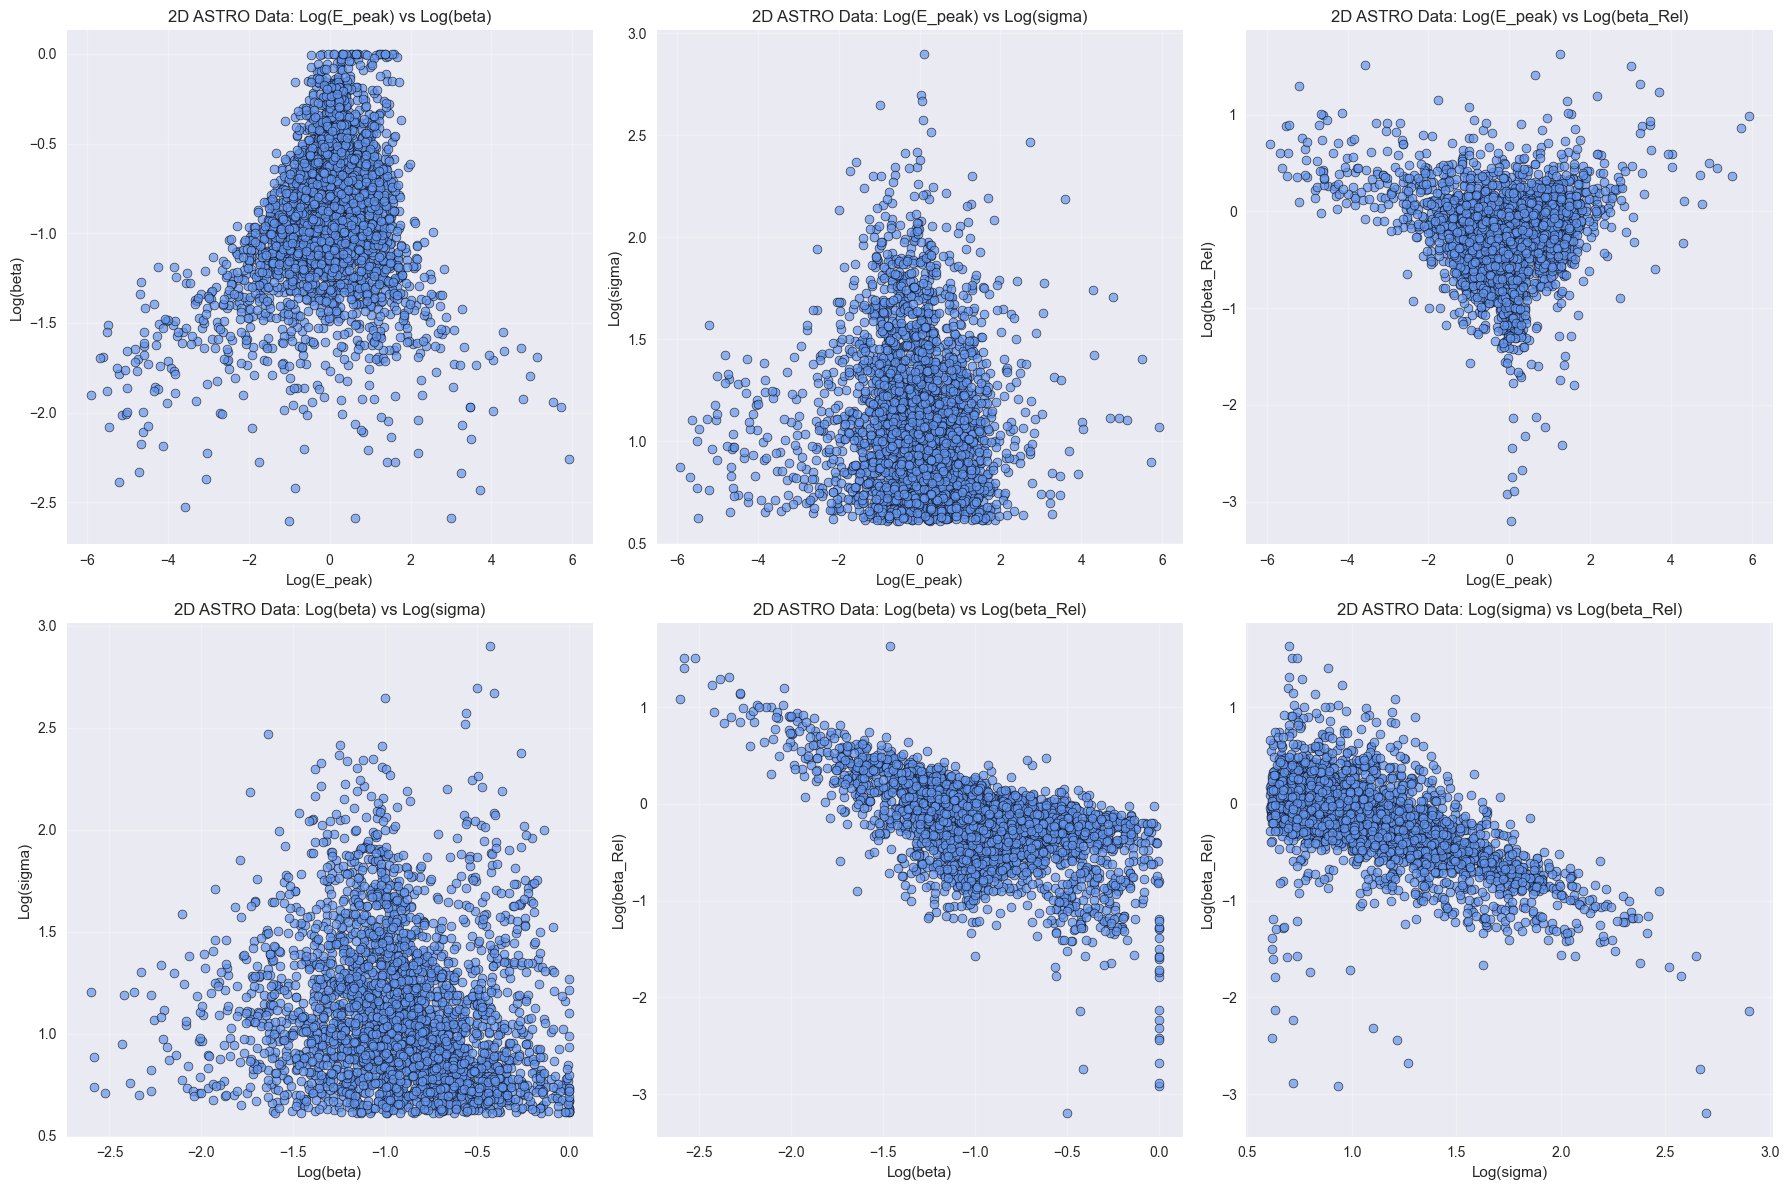

In [5]:
# Crear figura con todas las combinaciones 2D
features = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']
feature_pairs = list(combinations(features, 2))

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (feat1, feat2) in enumerate(feature_pairs):
    ax = axes[idx]
    
    sns.scatterplot(
        data=df_astro,
        x=feat1,
        y=feat2,
        color="cornflowerblue",
        edgecolor='k',
        alpha=0.7,
        s=40,
        ax=ax
    )
    
    ax.set_title(f"2D ASTRO Data: {feat1} vs {feat2}")
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

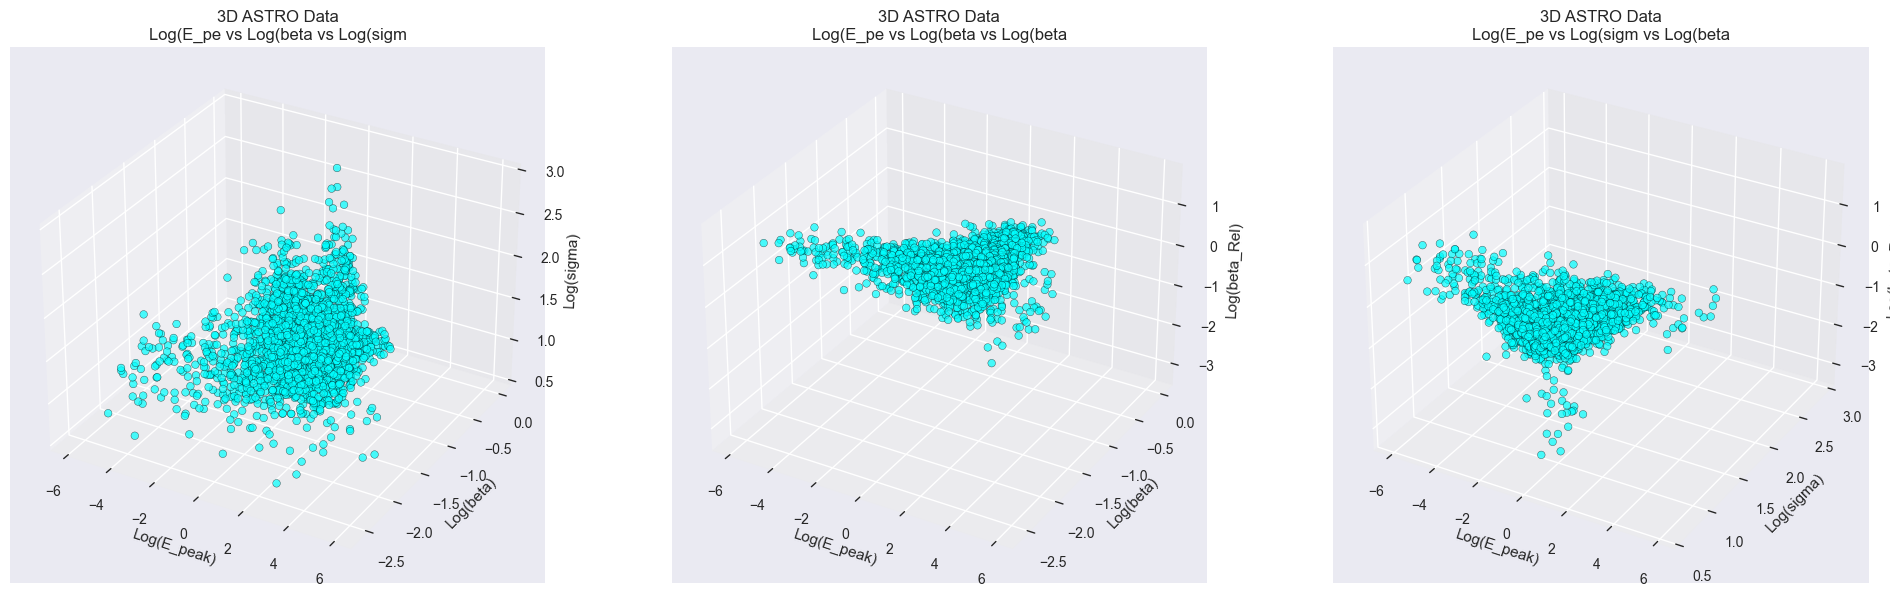

In [6]:
# Crear múltiples gráficos 3D con diferentes combinaciones
fig = plt.figure(figsize=(20, 6))

# Combinaciones 3D más representativas
combinations_3d = [
    ('Log(E_peak)', 'Log(beta)', 'Log(sigma)'),
    ('Log(E_peak)', 'Log(beta)', 'Log(beta_Rel)'),
    ('Log(E_peak)', 'Log(sigma)', 'Log(beta_Rel)'),
    ('Log(beta)', 'Log(sigma)', 'Log(beta_Rel)')
]

for idx, (feat1, feat2, feat3) in enumerate(combinations_3d[:3]):  # Solo 3 gráficos
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    
    x = df_astro[feat1]
    y = df_astro[feat2] 
    z = df_astro[feat3]
    labels = df_astro['class']
    
    scatter = ax.scatter(x, y, z, c=labels, cmap='cool', edgecolor='k', alpha=0.7, s=30)
    
    ax.set_xlabel(feat1)
    ax.set_ylabel(feat2)
    ax.set_zlabel(feat3)
    ax.set_title(f'3D ASTRO Data\n{feat1[:8]} vs {feat2[:8]} vs {feat3[:8]}')

plt.tight_layout()
plt.show()

In [7]:

# Seleccionamos las features dinámicamente
X = df_astro[features].values
y = df_astro[target].values

# Hacemos una división estratificada para mantener la proporción de clases
# First stratified split: 60% train, 40% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# Second stratified split: 50% val, 50% test from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
print("Forma de X_train_scaled:", X_train_scaled.shape)
print("Forma de X_val_scaled:"  , X_val_scaled.shape)
print("Forma de X_test_scaled:", X_test_scaled.shape)

Forma de X_train_scaled: (1698, 4)
Forma de X_val_scaled: (566, 4)
Forma de X_test_scaled: (567, 4)


In [9]:
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma)', 'Log(beta_Rel)']

selected_nu = 0.001
selected_gamma = 0.02

# Entrenar modelo final con todos los datos astro (train + val)
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

# Scaler final
scaler_final = StandardScaler()
X_final_train_scaled = scaler_final.fit_transform(X_final_train)

# Modelo final
final_model = OneClassSVM(kernel='rbf', nu=selected_nu, gamma=selected_gamma)
final_model.fit(X_final_train_scaled)

OneClassSVM(gamma=0.02, nu=0.001)

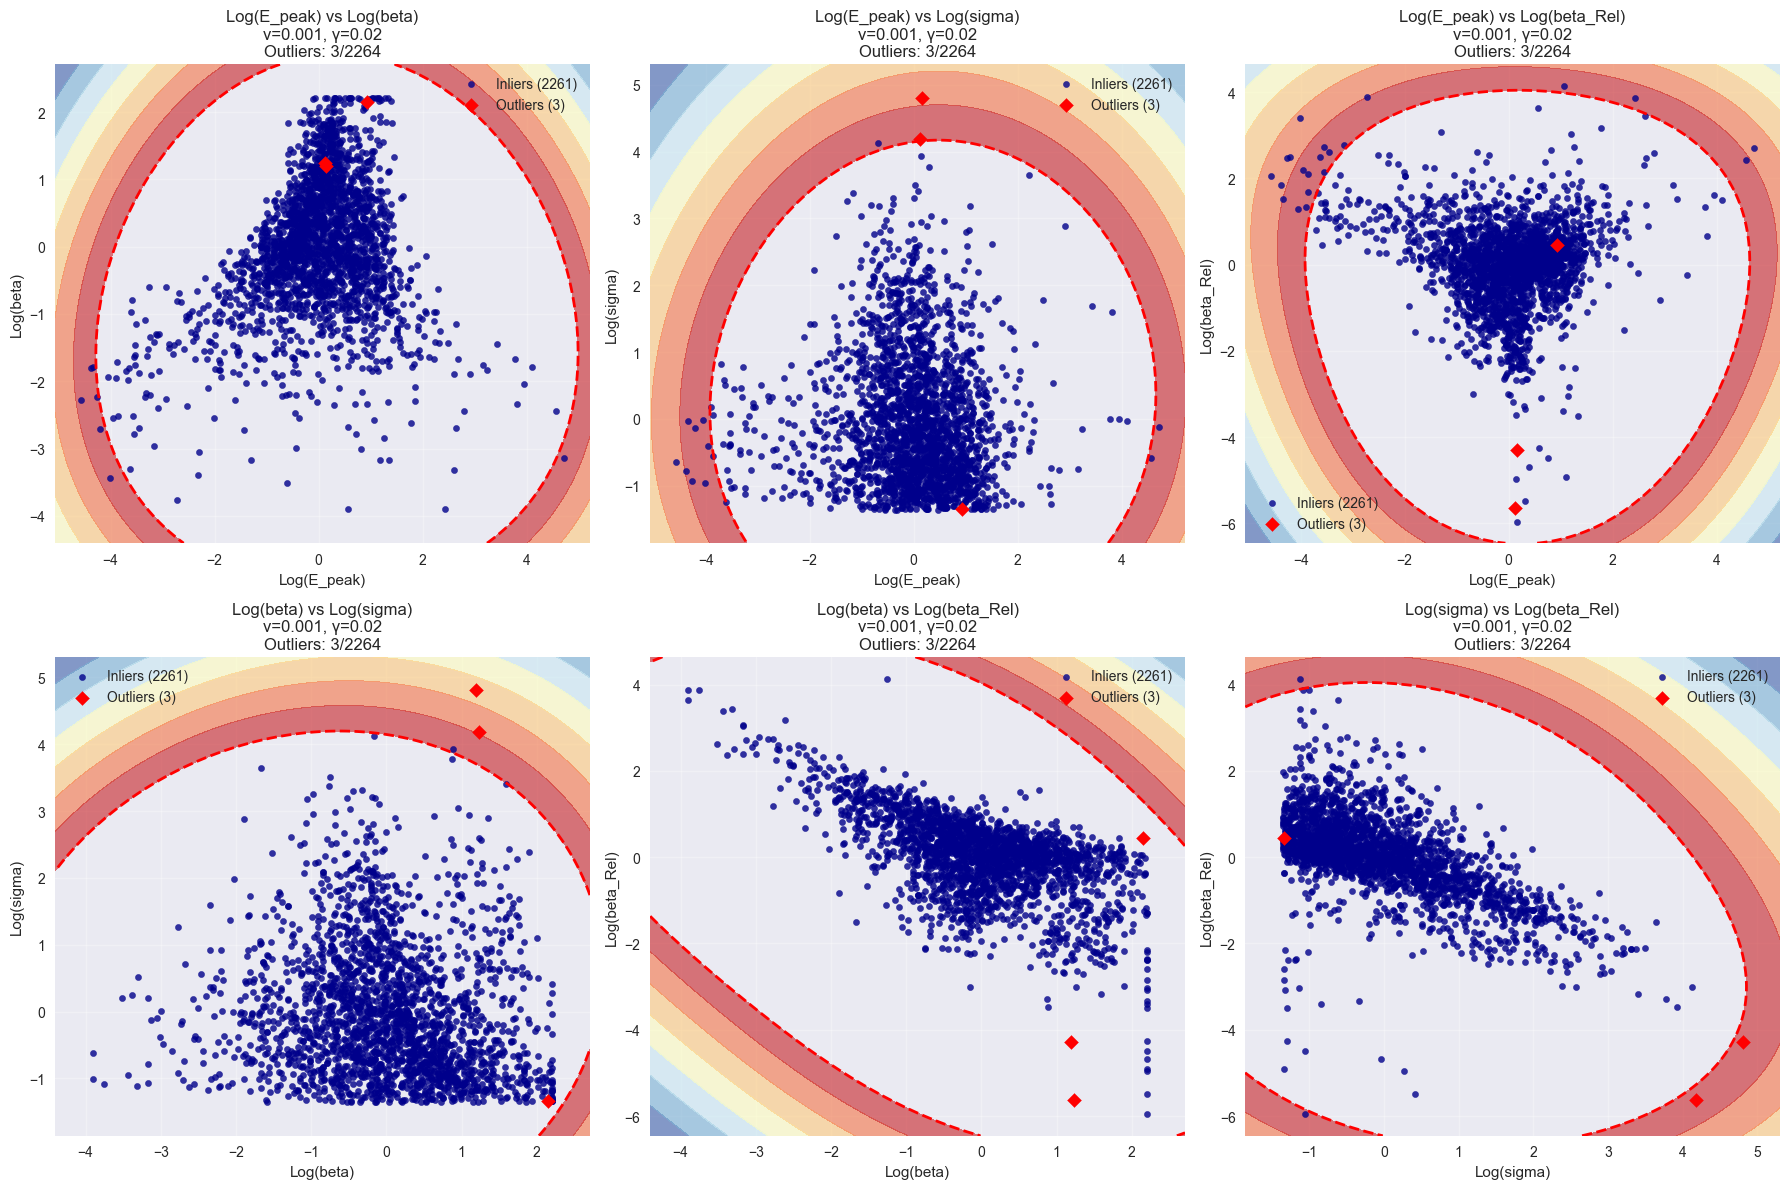

In [10]:
feature_pairs = list(combinations(range(len(feature_names)), 2))
n_pairs = len(feature_pairs)

# Grid layout
cols = 3
rows = int(np.ceil(n_pairs / cols))
fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

# Predecir una vez para todos
X_scaled_full = scaler_final.transform(X_final_train)
y_pred = final_model.predict(X_scaled_full)

# Crear visualizaciones 2D
for i, (feature_idx1, feature_idx2) in enumerate(feature_pairs):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    
    # Crear grid para visualización (como en tu código)
    other_dims = [j for j in range(len(feature_names)) if j not in [feature_idx1, feature_idx2]]
    mean_values = [X_scaled_full[:, dim].mean() for dim in other_dims]
    
    x_min = X_scaled_full[:, feature_idx1].min() - 0.5
    x_max = X_scaled_full[:, feature_idx1].max() + 0.5
    y_min = X_scaled_full[:, feature_idx2].min() - 0.5
    y_max = X_scaled_full[:, feature_idx2].max() + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 150), np.linspace(y_min, y_max, 150))
    
    # Grid 4D completo
    grid_points = []
    for k in range(xx.ravel().shape[0]):
        point_4d = [0] * len(feature_names)
        point_4d[feature_idx1] = xx.ravel()[k]
        point_4d[feature_idx2] = yy.ravel()[k]
        for j, other_dim in enumerate(other_dims):
            point_4d[other_dim] = mean_values[j]
        grid_points.append(point_4d)
    
    grid_4d = np.array(grid_points)
    Z = final_model.decision_function(grid_4d)
    Z = Z.reshape(xx.shape)
    
    # Visualización con el mismo estilo
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 8), cmap='RdYlBu_r', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red', linestyles='--')
    
    # Separar inliers y outliers
    inliers_mask = y_pred == 1
    outliers_mask = y_pred == -1
    
    # Plotear puntos con el mismo estilo
    ax.scatter(X_scaled_full[inliers_mask, feature_idx1], X_scaled_full[inliers_mask, feature_idx2], 
              c='darkblue', s=20, alpha=0.8, label=f'Inliers ({np.sum(inliers_mask)})')
    
    if np.any(outliers_mask):
        ax.scatter(X_scaled_full[outliers_mask, feature_idx1], X_scaled_full[outliers_mask, feature_idx2], 
                  c='red', s=50, alpha=1.0, marker='D', label=f'Outliers ({np.sum(outliers_mask)})')
    
    ax.set_xlabel(feature_names[feature_idx1])
    ax.set_ylabel(feature_names[feature_idx2])
    ax.set_title(f'{feature_names[feature_idx1]} vs {feature_names[feature_idx2]}\n'
                f'ν={selected_nu}, γ={selected_gamma}\n'
                f'Outliers: {np.sum(outliers_mask)}/{len(X_final_train)}')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Ocultar subplots vacíos
for i in range(len(feature_pairs), rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [11]:
feature_triplets = list(combinations(range(len(feature_names)), 3))
n_triplets = len(feature_triplets)

# Grid layout 3D
cols_3d = 2
rows_3d = int(np.ceil(n_triplets / cols_3d))
fig = plt.figure(figsize=(15, 7*rows_3d))

# Separar inliers y outliers (ya calculado arriba)
inliers_mask = y_pred == 1
outliers_mask = y_pred == -1

# Crear visualizaciones 3D
for i, (f1_idx, f2_idx, f3_idx) in enumerate(feature_triplets):
    ax = fig.add_subplot(rows_3d, cols_3d, i+1, projection='3d')
    
    # Plotear inliers con borde para más definición
    ax.scatter(X_scaled_full[inliers_mask, f1_idx], 
               X_scaled_full[inliers_mask, f2_idx], 
               X_scaled_full[inliers_mask, f3_idx],
               c='lightblue', s=30, alpha=0.7, 
               edgecolor='blue', linewidth=0.5,  # <- Agregar estas líneas
               label=f'Inliers ({np.sum(inliers_mask)})')
    
    if np.any(outliers_mask):
        ax.scatter(X_scaled_full[outliers_mask, f1_idx], 
                   X_scaled_full[outliers_mask, f2_idx], 
                   X_scaled_full[outliers_mask, f3_idx],
                   c='red', s=100, alpha=1.0, marker='D', 
                   edgecolor='darkred', linewidth=1,
                   label=f'Outliers ({np.sum(outliers_mask)})')
    
    ax.set_xlabel(feature_names[f1_idx])
    ax.set_ylabel(feature_names[f2_idx])
    ax.set_zlabel(feature_names[f3_idx])
    ax.set_title(f'{feature_names[f1_idx]} vs {feature_names[f2_idx]} vs {feature_names[f3_idx]}\n'
                f'ν={selected_nu}, γ={selected_gamma} | Outliers: {np.sum(outliers_mask)}/{len(X_final_train)}')
    ax.legend()

plt.tight_layout()
plt.show()


In [12]:
# ESTADÍSTICAS DEL MODELO
decision_scores = final_model.decision_function(X_scaled_full)

n_inliers = np.sum(y_pred == 1)
n_outliers = np.sum(y_pred == -1)
total_samples = len(y_pred)

print(f"Total de muestras: {total_samples}")
print(f"Inliers detectados: {n_inliers} ({n_inliers/total_samples*100:.2f}%)")
print(f"Outliers detectados: {n_outliers} ({n_outliers/total_samples*100:.2f}%)")
print(f"Parámetros del modelo:")
print(f"  - nu: {final_model.nu}")
print(f"  - gamma: {final_model.gamma}")
print(f"  - kernel: {final_model.kernel}")

# Top 5 outliers más extremos
if n_outliers > 0:
    outlier_indices = np.where(y_pred == -1)[0]
    outlier_scores = decision_scores[outlier_indices]
    extreme_outliers = outlier_indices[np.argsort(outlier_scores)[:5]]
    
    print(f"\nTop 5 outliers más extremos:")
    for idx in extreme_outliers:
        print(f"  Índice {idx}: score = {decision_scores[idx]:.4f}")
        features_str = ", ".join([f'{feature_names[j]}={X_final_train[idx, j]:.3f}' for j in range(len(feature_names))])
        print(f"    [{features_str}]")

Total de muestras: 2264
Inliers detectados: 2261 (99.87%)
Outliers detectados: 3 (0.13%)
Parámetros del modelo:
  - nu: 0.001
  - gamma: 0.02
  - kernel: rbf

Top 5 outliers más extremos:
  Índice 2180: score = -0.0002
    [Log(E_peak)=0.100, Log(beta)=-0.429, Log(sigma)=2.899, Log(beta_Rel)=-2.140]
  Índice 987: score = -0.0001
    [Log(E_peak)=1.095, Log(beta)=-0.024, Log(sigma)=0.616, Log(beta_Rel)=-0.022]
  Índice 396: score = -0.0001
    [Log(E_peak)=0.073, Log(beta)=-0.411, Log(sigma)=2.668, Log(beta_Rel)=-2.744]


# Predict on UNIDs

In [13]:
# Cargar datos UnIDs
unids_path = "../data/unids_log.txt"
df_unids = pd.read_csv(unids_path, sep='\s+')

print("Datos UnIDs cargados:")
print(f"Shape: {df_unids.shape}")
print("Primeras filas:")
display(df_unids.head())

# Verificar columnas disponibles
print(f"Columnas disponibles: {list(df_unids.columns)}")

Datos UnIDs cargados:
Shape: (1125, 5)
Primeras filas:


Log(E_peak)  Log(beta)  Log(sigma_det)  Log(beta_Rel)  number
0     0.400175  -1.047208        0.869208       0.212452       0
1     0.169733  -0.380594        0.733598      -0.113037       1
2     0.203142  -0.168578        1.033058      -0.430366       2
3    -0.031074  -0.557363        0.881133      -0.201588       3
4    -0.351835  -0.493901        0.630916      -0.246028       4

Columnas disponibles: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 'number']


In [14]:
# Extraer características 4F
feature_cols = ["Log(E_peak)", "Log(beta)", "Log(sigma_det)", "Log(beta_Rel)"]
X_unids = df_unids[feature_cols].values

print(f"Características extraídas: {feature_cols}")
print(f"Shape características UnIDs: {X_unids.shape}")

Características extraídas: ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']
Shape características UnIDs: (1125, 4)


In [15]:
# Escalar características UnIDs
X_unids_scaled = scaler_final.transform(X_unids)

decision_scores = final_model.decision_function(X_unids_scaled)

unids_preds = final_model.predict(X_unids_scaled)

n_outliers = np.sum(unids_preds == -1)
outlier_percentage = n_outliers / len(unids_preds) * 100

print(f"RESULTADOS DE PREDICCIÓN:")
print(f"  - Total UnIDs analizadas: {len(unids_preds)}")
print(f"  - Outliers detectados: {n_outliers} ({outlier_percentage:.1f}%)")
print(f"  - Inliers detectados: {np.sum(unids_preds == 1)} ({100-outlier_percentage:.1f}%)")

# Calcular anomaly scores y rankings
# Invertir scores: valores más altos = más anómalos
anom_scores = -decision_scores

# Escalar a percentiles [0, 100]
anom_percent = MinMaxScaler(feature_range=(0, 100)).fit_transform(anom_scores.reshape(-1, 1)).flatten()

# Agregar resultados al DataFrame
df_unids_results = df_unids.copy()
df_unids_results["svm_score"] = decision_scores
df_unids_results["prediction"] = unids_preds
df_unids_results["Anomaly_Score"] = anom_scores
df_unids_results["Anomaly_Rank(%)"] = anom_percent

print("Scores calculados y agregados al DataFrame")

RESULTADOS DE PREDICCIÓN:
  - Total UnIDs analizadas: 1125
  - Outliers detectados: 3 (0.3%)
  - Inliers detectados: 1122 (99.7%)
Scores calculados y agregados al DataFrame


In [16]:
# Filtrar solo outliers y ordenar por anomaly rank
outliers_only = df_unids_results[df_unids_results["prediction"] == -1].copy()
outliers_sorted = outliers_only.sort_values(by="Anomaly_Rank(%)", ascending=False)

# Top 10 outliers más anómalos
top_10_outliers = outliers_sorted.head(10)

print(f"TOP 10 CANDIDATOS MÁS ANÓMALOS:")

# Mostrar información relevante
display_cols = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)', 
                'svm_score', 'Anomaly_Score', 'Anomaly_Rank(%)']

if 'number' in df_unids_results.columns:
    display_cols = ['number'] + display_cols

display(top_10_outliers[display_cols].round(4))

TOP 10 CANDIDATOS MÁS ANÓMALOS:


number  Log(E_peak)  Log(beta)  Log(sigma_det)  Log(beta_Rel)  svm_score  \
307     307       1.5101     0.0000          0.6173        -3.0458    -0.0526   
923     923      -0.2177    -0.2478          0.6276         0.7369    -0.0280   
285     285      -0.7468    -1.2457          0.6598         1.8748    -0.0232   

     Anomaly_Score  Anomaly_Rank(%)  
307         0.0526         100.0000  
923         0.0280          91.0137  
285         0.0232          89.2555

In [17]:
# Estadísticas de los outliers
print(f"\nESTADÍSTICAS DE OUTLIERS:")
print(f"  - Anomaly Score promedio: {outliers_only['Anomaly_Score'].mean():.4f} ± {outliers_only['Anomaly_Score'].std():.4f}")
print(f"  - Anomaly Rank promedio: {outliers_only['Anomaly_Rank(%)'].mean():.1f}% ± {outliers_only['Anomaly_Rank(%)'].std():.1f}%")
print(f"  - SVM Score promedio: {outliers_only['svm_score'].mean():.4f} ± {outliers_only['svm_score'].std():.4f}")


ESTADÍSTICAS DE OUTLIERS:
  - Anomaly Score promedio: 0.0346 ± 0.0158
  - Anomaly Rank promedio: 93.4% ± 5.8%
  - SVM Score promedio: -0.0346 ± 0.0158


In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis Estadístico del Modelo OCSVM en UNIDs', fontsize=16, fontweight='bold', y=0.98)

# 1. Distribución de Decision Scores CON ESTADÍSTICAS
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(decision_scores, bins=50, alpha=0.7, color='skyblue', 
                           edgecolor='black', density=True)

# Añadir curva de densidad suavizada
x_smooth = np.linspace(decision_scores.min(), decision_scores.max(), 100)
density = stats.gaussian_kde(decision_scores)
ax1.plot(x_smooth, density(x_smooth), 'navy', linewidth=2, label='Densidad estimada')

# Líneas de referencia
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Frontera (score=0)')
ax1.axvline(decision_scores.mean(), color='green', linestyle='--', linewidth=2,
           label=f'Media: {decision_scores.mean():.3f}')
ax1.axvline(np.median(decision_scores), color='orange', linestyle='--', linewidth=2,
           label=f'Mediana: {np.median(decision_scores):.3f}')

# Estadísticas adicionales
std_dev = decision_scores.std()
ax1.fill_betweenx([0, ax1.get_ylim()[1]], decision_scores.mean()-std_dev, 
                  decision_scores.mean()+std_dev, alpha=0.2, color='green', 
                  label=f'±1σ: {std_dev:.3f}')

ax1.set_xlabel('SVM Decision Score')
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_title('Distribución de Decision Scores\n(Análisis de Normalidad)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Texto con estadísticas
stats_text = f'n = {len(decision_scores)}\nSkewness: {stats.skew(decision_scores):.3f}\nKurtosis: {stats.kurtosis(decision_scores):.3f}'
ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=9, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Distribución de Anomaly Ranks CON PERCENTILES
ax2 = axes[0, 1]
ax2.hist(anom_percent, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')

# Percentiles importantes
percentiles = [50, 75, 90, 95, 99]
colors = ['blue', 'orange', 'red', 'darkred', 'purple']
for p, color in zip(percentiles, colors):
    value = np.percentile(anom_percent, p)
    ax2.axvline(value, color=color, linestyle='--', linewidth=2, 
               label=f'P{p}: {value:.1f}%')

ax2.set_xlabel('Anomaly Rank (%)')
ax2.set_ylabel('Frecuencia')
ax2.set_title('Distribución de Anomaly Rankings\n(Análisis de Percentiles)')
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Comparación Inliers vs Outliers
ax3 = axes[1, 0]
outliers_scores = anom_percent[unids_preds == -1]
inliers_scores = anom_percent[unids_preds == 1]

# Histograma
bins = np.linspace(0, 100, 31)
ax3.hist([inliers_scores, outliers_scores], bins=bins, alpha=0.7,
         color=['lightblue', 'red'], label=[f'Inliers (n={len(inliers_scores)})', 
                                           f'Outliers (n={len(outliers_scores)})'],
         edgecolor='black')

# Añadir líneas de medias
ax3.axvline(inliers_scores.mean(), color='blue', linestyle='-', linewidth=2,
           label=f'Media Inliers: {inliers_scores.mean():.1f}%')
ax3.axvline(outliers_scores.mean(), color='darkred', linestyle='-', linewidth=2,
           label=f'Media Outliers: {outliers_scores.mean():.1f}%')

ax3.set_xlabel('Anomaly Rank (%)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Separación Inliers vs Outliers\n(Validación del Modelo)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Test estadístico
stat, p_value = stats.mannwhitneyu(outliers_scores, inliers_scores, alternative='greater')
test_text = f'Mann-Whitney U test:\np-value: {p_value:.2e}'
ax3.text(0.02, 0.98, test_text, transform=ax3.transAxes, fontsize=9,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Scatter con regiones de interés
ax4 = axes[1, 1]
colors = ['red' if pred == -1 else 'blue' for pred in unids_preds]
sizes = [40 if pred == -1 else 20 for pred in unids_preds]

scatter = ax4.scatter(decision_scores, anom_percent, c=colors, alpha=0.6, s=sizes,
                     edgecolors='black', linewidth=0.5)

# Regiones de interés
ax4.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Frontera decisión')
ax4.axhline(90, color='red', linestyle='--', alpha=0.7, label='Top 10% anomalías')
ax4.axhline(95, color='darkred', linestyle='--', alpha=0.7, label='Top 5% anomalías')

# Destacar zona de interés (outliers extremos)
extreme_mask = (unids_preds == -1) & (anom_percent > 95)
if np.any(extreme_mask):
    ax4.scatter(decision_scores[extreme_mask], anom_percent[extreme_mask], 
               s=100, facecolors='none', edgecolors='yellow', linewidth=3,
               label=f'Outliers extremos (n={np.sum(extreme_mask)})')

# Correlación
correlation = np.corrcoef(decision_scores, anom_percent)[0, 1]
ax4.text(0.02, 0.98, f'Correlación: {correlation:.3f}', transform=ax4.transAxes, 
         fontsize=11, verticalalignment='top', fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

ax4.set_xlabel('SVM Decision Score')
ax4.set_ylabel('Anomaly Rank (%)')
ax4.set_title('Relación Decision Score vs Anomaly Rank\n(Coherencia del Modelo)')
ax4.legend(fontsize=9, loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# GRID DE VISUALIZACIONES 2D DE UNIDs CON IDs DE ANOMALÍAS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Todas las combinaciones 2D de las 4 características
feature_pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']

# Separar inliers y outliers
inliers_mask = unids_preds == 1
outliers_mask = unids_preds == -1
top_10_indices = top_10_outliers.index

for idx, (i, j) in enumerate(feature_pairs):
    ax = axes[idx//3, idx%3]
    
    # Plot inliers con el estilo gold
    ax.scatter(X_unids[inliers_mask, i], X_unids[inliers_mask, j],
               c='gold', alpha=0.6, s=30, edgecolors='black', linewidth=0.3,
               label=f'Inliers (astro-like) ({np.sum(inliers_mask)})')
    
    # Plot outliers con gradient de colores según anomaly rank
    if np.any(outliers_mask):
        scatter = ax.scatter(X_unids[outliers_mask, i], X_unids[outliers_mask, j],
                            c=anom_percent[outliers_mask], cmap='Reds', s=60,
                            alpha=0.8, edgecolors='black', linewidth=0.5, 
                            label=f'Outliers (anomalous) ({np.sum(outliers_mask)})')
        
        # Colorbar solo en el subplot superior derecho para no saturar
        if idx == 2:  # subplot (0,2) - esquina superior derecha
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Anomaly Rank %', fontsize=10)
    
    # Destacar top 10 con círculos amarillos
    if len(top_10_indices) > 0:
        ax.scatter(X_unids[top_10_indices, i], X_unids[top_10_indices, j],
                   s=120, facecolors='none', edgecolors='yellow', linewidth=3,
                   label=f'Top 10 Anomalies', marker='o')
        
        # Añadir etiquetas de ID para top 10
        for unid_idx in top_10_indices:
            x = X_unids[unid_idx, i]
            y = X_unids[unid_idx, j]
            
            # Obtener el número del UNID
            if 'number' in df_unids_results.columns:
                unid_id = int(df_unids_results.loc[unid_idx, 'number'])
            else:
                unid_id = unid_idx
            
            # Posicionar texto ligeramente desplazado para evitar solapamiento
            offset_x = (X_unids[:, i].max() - X_unids[:, i].min()) * 0.02
            offset_y = (X_unids[:, j].max() - X_unids[:, j].min()) * 0.02
            
            ax.text(x + offset_x, y + offset_y, str(unid_id), 
                   color='black', fontsize=8, fontweight='bold',
                   ha='left', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))
    
    # Configuración de ejes y título
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f'{feature_names[i]} vs {feature_names[j]}\n'
                f'UNIDs: Inliers vs Anomalies with Top 10 IDs')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

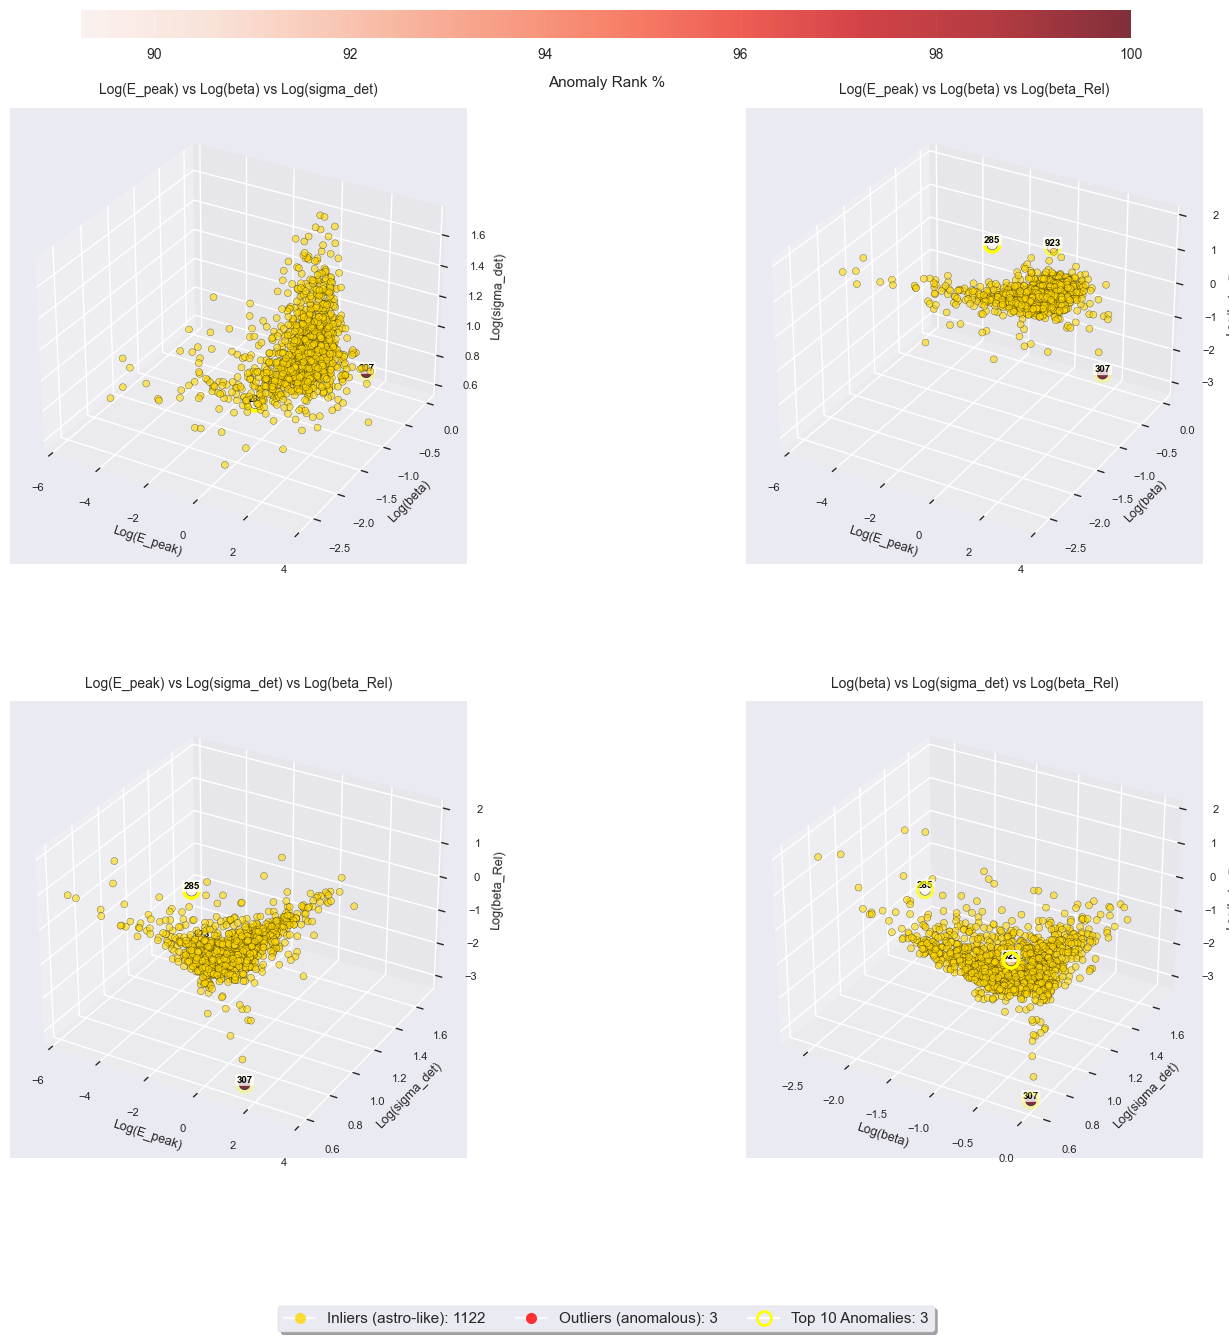

In [20]:
# GRID DE VISUALIZACIONES 3D DE UNIDs
feature_names = ['Log(E_peak)', 'Log(beta)', 'Log(sigma_det)', 'Log(beta_Rel)']
feature_triplets = list(combinations(range(len(feature_names)), 3))
n_triplets = len(feature_triplets)

# Grid layout 3D optimizado
cols_3d = 2
rows_3d = int(np.ceil(n_triplets / cols_3d))
fig = plt.figure(figsize=(15, 7*rows_3d))

# Separar inliers y outliers
inliers_mask = unids_preds == 1
outliers_mask = unids_preds == -1
top_10_indices = top_10_outliers.index

# Conteos para leyenda unificada
n_inliers = np.sum(inliers_mask)
n_outliers = np.sum(outliers_mask)
n_top10 = len(top_10_indices)

# Crear visualizaciones 3D
for i, (f1_idx, f2_idx, f3_idx) in enumerate(feature_triplets):
    ax = fig.add_subplot(rows_3d, cols_3d, i+1, projection='3d')
    
    # Plot inliers
    ax.scatter(X_unids[inliers_mask, f1_idx], 
               X_unids[inliers_mask, f2_idx], 
               X_unids[inliers_mask, f3_idx],
               c='gold', s=25, alpha=0.6, 
               edgecolor='black', linewidth=0.3)
    
    # Plot outliers con gradient de color según anomaly rank
    if np.any(outliers_mask):
        scatter = ax.scatter(X_unids[outliers_mask, f1_idx], 
                           X_unids[outliers_mask, f2_idx], 
                           X_unids[outliers_mask, f3_idx],
                           c=anom_percent[outliers_mask], cmap='Reds', s=60,
                           alpha=0.8, edgecolors='black', linewidth=0.4)
    
    # Destacar top 10 anomalías
    if len(top_10_indices) > 0:
        ax.scatter(X_unids[top_10_indices, f1_idx], 
                   X_unids[top_10_indices, f2_idx], 
                   X_unids[top_10_indices, f3_idx],
                   s=120, facecolors='none', edgecolors='yellow', 
                   linewidth=2.5)
        
        # Añadir etiquetas de ID con mejor posicionamiento
        for idx in top_10_indices:
            x = X_unids[idx, f1_idx]
            y = X_unids[idx, f2_idx] 
            z = X_unids[idx, f3_idx]
            
            # Obtener el número del UNID
            if 'number' in df_unids_results.columns:
                unid_id = int(df_unids_results.loc[idx, 'number'])
            else:
                unid_id = idx
            
            ax.text(x, y, z, str(unid_id), fontsize=7, color='black', 
                   fontweight='bold', ha='center', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                            alpha=0.8, edgecolor='none'))
    
    # Configuración de ejes más compacta
    ax.set_xlabel(feature_names[f1_idx], fontsize=9)
    ax.set_ylabel(feature_names[f2_idx], fontsize=9)
    ax.set_zlabel(feature_names[f3_idx], fontsize=9)
    
    # Título más compacto
    title_short = f'{feature_names[f1_idx]} vs {feature_names[f2_idx]} vs {feature_names[f3_idx]}'
    ax.set_title(title_short, fontsize=10, pad=10)
    
    # Ajustar tamaño de ticks
    ax.tick_params(axis='both', which='major', labelsize=8)

# Colorbar unificado en la parte superior
if np.any(outliers_mask):
    # Crear un scatter dummy para el colorbar
    dummy_scatter = plt.scatter([], [], c=[], cmap='Reds', s=60, alpha=0.8)
    dummy_scatter.set_array(anom_percent[outliers_mask])
    
    # Colorbar en la parte superior
    cbar_ax = fig.add_axes([0.15, 0.95, 0.7, 0.02])  # [left, bottom, width, height]
    cbar = plt.colorbar(dummy_scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Anomaly Rank %', fontsize=11, labelpad=10)

# Leyenda unificada en la parte inferior
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gold', 
               markeredgecolor='black', markersize=8, alpha=0.8,
               label=f'Inliers (astro-like): {n_inliers}'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markeredgecolor='black', markersize=8, alpha=0.8,
               label=f'Outliers (anomalous): {n_outliers}'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
               markeredgecolor='yellow', markersize=10, markeredgewidth=2,
               label=f'Top 10 Anomalies: {n_top10}')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          bbox_to_anchor=(0.5, 0.02), fontsize=11, frameon=True, 
          fancybox=True, shadow=True)

# Ajustar layout con más espacio para leyenda y colorbar
plt.subplots_adjust(top=0.90, bottom=0.15, left=0.05, right=0.95, 
                   hspace=0.3, wspace=0.2)
plt.show()


In [21]:
# ESTADÍSTICAS DETALLADAS DE UNIDs
print(f"\nESTADÍSTICAS UNIDs")
n_inliers = np.sum(inliers_mask)
n_outliers = np.sum(outliers_mask)
total_unids = len(unids_preds)

print(f"Total UNIDs analizados: {total_unids}")
print(f"Inliers (astro-like): {n_inliers} ({n_inliers/total_unids*100:.1f}%)")
print(f"Outliers (anomalous): {n_outliers} ({n_outliers/total_unids*100:.1f}%)")

print(f"\nTOP 10 ANOMALÍAS ETIQUETADAS:")
for i, idx in enumerate(top_10_indices):
    if 'number' in df_unids_results.columns:
        unid_id = int(df_unids_results.loc[idx, 'number'])
        rank = df_unids_results.loc[idx, 'Anomaly_Rank(%)']
        print(f"  {i+1:2d}. UNID {unid_id:3d} (Rank: {rank:5.1f}%)")
    else:
        rank = df_unids_results.loc[idx, 'Anomaly_Rank(%)']
        print(f"  {i+1:2d}. Índice {idx:3d} (Rank: {rank:5.1f}%)")


ESTADÍSTICAS UNIDs
Total UNIDs analizados: 1125
Inliers (astro-like): 1122 (99.7%)
Outliers (anomalous): 3 (0.3%)

TOP 10 ANOMALÍAS ETIQUETADAS:
   1. UNID 307 (Rank: 100.0%)
   2. UNID 923 (Rank:  91.0%)
   3. UNID 285 (Rank:  89.3%)


# Compare UNIDs most anomalous vs ANN most DM-like

In [22]:
# Cargar resultados del consenso ANN 4F
ann_consensus = pd.read_csv('../data/results/ann/4F/consensus_analysis_ann_4f.csv')
print(f"Resultados ANN 4F cargados: {len(ann_consensus)} fuentes")

# Cargar resultados OCSVM 4F
ocsvm_results = df_unids_results.copy()  # O cargar desde archivo si está guardado
print(f"Resultados OCSVM 4F cargados: {len(ocsvm_results)} fuentes")

# Verificar mismo número de fuentes
if len(ann_consensus) != len(ocsvm_results):
    print(f" ADVERTENCIA: Diferentes números de fuentes - ANN: {len(ann_consensus)}, OCSVM: {len(ocsvm_results)}")
else:
    print(f"Mismo número de fuentes: {len(ann_consensus)}")

Resultados ANN 4F cargados: 1125 fuentes
Resultados OCSVM 4F cargados: 1125 fuentes
Mismo número de fuentes: 1125


In [23]:
print("Resultados (top unids) consenso ANN 4F:")
ann_consensus.head()

Resultados (top unids) consenso ANN 4F:


Source_ID    E_peak    Beta  Sigma_det  Beta_Rel  log_E_peak  log_Beta  \
0        371  13.85500  0.2306     5.0215  0.999133    1.141607 -0.637141   
1        821   1.54370  0.6922     9.8576  0.311182    0.188563 -0.159768   
2        596   1.27120  0.4036    19.3727  0.230922    0.104214 -0.394049   
3        556   0.07633  0.0593     4.2719  1.487352   -1.117305 -1.226945   
4        106  13.89300  0.1439    11.8161  0.610841    1.142796 -0.841939   

   log_Sigma_det  log_Beta_Rel  Prob_Run1  Prob_Run2  Prob_Run3  Std_Run1  \
0       0.700833     -0.000377   0.774770   0.772964   0.806131  0.399808   
1       0.993771     -0.506986   0.715743   0.712077   0.802501  0.331793   
2       1.287190     -0.636535   0.649508   0.711889   0.653177  0.407760   
3       0.630621      0.172414   0.637254   0.697927   0.651670  0.248562   
4       1.072474     -0.214072   0.592502   0.653579   0.627548  0.229078   

   Std_Run2  Std_Run3  Mean_Prob_Consensus  Std_Prob_Consensus  \
0  0.416598  0.372890             0.784622            0.018650   
1  0.334242  0.398867             0.743440            0.051181   
2  0.384005  0.292166             0.671525            0.035004   
3  0.206301  0.193634             0.662284            0.031699   
4  0.263266  0.297331             0.624543            0.030649   

   Min_Prob_Consensus  Max_Prob_Consensus  Mean_Uncertainty_Consensus  
0            0.772964            0.806131                    0.396432  
1            0.712077            0.802501                    0.354967  
2            0.649508            0.711889                    0.361310  
3            0.637254            0.697927                    0.216166  
4            0.592502            0.653579                    0.263225

In [24]:
print('Resultados (todos) OCSVM 2F:')
ocsvm_results.head()

Resultados (todos) OCSVM 2F:


Log(E_peak)  Log(beta)  Log(sigma_det)  Log(beta_Rel)  number  svm_score  \
0     0.400175  -1.047208        0.869208       0.212452       0   0.180777   
1     0.169733  -0.380594        0.733598      -0.113037       1   0.095487   
2     0.203142  -0.168578        1.033058      -0.430366       2   0.108184   
3    -0.031074  -0.557363        0.881133      -0.201588       3   0.144364   
4    -0.351835  -0.493901        0.630916      -0.246028       4   0.105524   

   prediction  Anomaly_Score  Anomaly_Rank(%)  
0           1      -0.180777        14.799261  
1           1      -0.095487        45.938033  
2           1      -0.108184        41.302477  
3           1      -0.144364        28.093559  
4           1      -0.105524        42.273633

In [25]:
# Verificar alineamiento de IDs
ann_ids = ann_consensus['Source_ID'].values
ocsvm_ids = ocsvm_results['number'].values if 'number' in ocsvm_results.columns else ocsvm_results.index.values

ids_aligned = np.array_equal(ann_ids, ocsvm_ids)

if ids_aligned:
    print("Los IDs están alineados correctamente")
    ann_final = ann_consensus.copy()
    ocsvm_final = ocsvm_results.copy()
else:
    print("Los IDs NO están alineados - procediendo a alinear...")
    print(f"   Primeros 5 IDs ANN: {ann_ids[:5]}")
    print(f"   Primeros 5 IDs OCSVM: {ocsvm_ids[:5]}")
    
    # Alinear por ID común
    if 'number' in ocsvm_results.columns:
        ann_final = ann_consensus.sort_values('Source_ID').reset_index(drop=True)
        ocsvm_final = ocsvm_results.sort_values('number').reset_index(drop=True)
        
        # Verificar alineamiento después de ordenar
        if np.array_equal(ann_final['Source_ID'].values, ocsvm_final['number'].values):
            print("IDs alineados correctamente después de ordenar")
        else:
            print("ERROR: No se pudieron alinear los IDs - revisar datos")
            # Mostrar diferencias
            ann_set = set(ann_final['Source_ID'].values)
            ocsvm_set = set(ocsvm_final['number'].values)
            print(f"   IDs solo en ANN: {ann_set - ocsvm_set}")
            print(f"   IDs solo en OCSVM: {ocsvm_set - ann_set}")
    else:
        print("ERROR: Columna 'number' no encontrada en OCSVM results")
        ann_final = ann_consensus.copy()
        ocsvm_final = ocsvm_results.copy()

Los IDs NO están alineados - procediendo a alinear...
   Primeros 5 IDs ANN: [371 821 596 556 106]
   Primeros 5 IDs OCSVM: [0 1 2 3 4]
IDs alineados correctamente después de ordenar


In [26]:
# CREAR DATAFRAME COMBINADO

# Verificar columnas necesarias existen
required_ann_cols = ['Source_ID', 'E_peak', 'Beta', 'log_E_peak', 'log_Beta', 'log_Sigma_det', 'log_Beta_Rel', 'Mean_Prob_Consensus', 'Std_Prob_Consensus']
required_ocsvm_cols = ['prediction', 'Anomaly_Score', 'Anomaly_Rank(%)']

missing_ann = [col for col in required_ann_cols if col not in ann_final.columns]
missing_ocsvm = [col for col in required_ocsvm_cols if col not in ocsvm_final.columns]

if missing_ann:
    print(f"Columnas faltantes en ANN: {missing_ann}")
if missing_ocsvm:
    print(f"Columnas faltantes en OCSVM: {missing_ocsvm}")

if not missing_ann and not missing_ocsvm:
    comparison_df = pd.DataFrame({
        # IDs y características originales
        'Source_ID': ann_final['Source_ID'].values,
        'E_peak': ann_final['E_peak'].values,
        'Beta': ann_final['Beta'].values,
        'Log_E_peak': ann_final['log_E_peak'].values,
        'Log_Beta': ann_final['log_Beta'].values,
        'Log_Sigma_det': ann_final['log_Sigma_det'].values,
        'log_Beta_Rel': ann_final['log_Beta_Rel'].values,
        
        # Resultados ANN 2F
        'ANN_Prob_Mean': ann_final['Mean_Prob_Consensus'].values,
        'ANN_Prob_Std': ann_final['Std_Prob_Consensus'].values,
        
        # Resultados OCSVM 2F
        'OCSVM_Prediction': ocsvm_final['prediction'].values,  # 1=inlier, -1=outlier
        'OCSVM_Anomaly_Score': ocsvm_final['Anomaly_Score'].values,
        'OCSVM_Anomaly_Rank': ocsvm_final['Anomaly_Rank(%)'].values,
    })
    
else:
    print("No se pudo crear el DataFrame combinado debido a columnas faltantes")
    comparison_df = None

In [27]:
# DIAGNÓSTICO DIRECTO ANN 4F vs OCSVM 4F
print("DIAGNÓSTICO ANN 4F vs OCSVM 4F")

print("-" * 60)
print(f"ANN 4F - Media: {comparison_df['ANN_Prob_Mean'].mean():.4f} | "
      f"Mediana: {comparison_df['ANN_Prob_Mean'].median():.4f} | "
      f"Rango: [{comparison_df['ANN_Prob_Mean'].min():.4f}-{comparison_df['ANN_Prob_Mean'].max():.4f}]")

print(f"OCSVM 4F - Media: {comparison_df['OCSVM_Anomaly_Rank'].mean():.1f}% | "
      f"Mediana: {comparison_df['OCSVM_Anomaly_Rank'].median():.1f}% | "
      f"Rango: [{comparison_df['OCSVM_Anomaly_Rank'].min():.1f}%-{comparison_df['OCSVM_Anomaly_Rank'].max():.1f}%]")

# IDENTIFICACIÓN DE CANDIDATOS
print("-" * 60)
print(f"\nIDENTIFICACIÓN DE CANDIDATOS:")
ann_threshold = np.percentile(comparison_df['ANN_Prob_Mean'], 95)
ocsvm_threshold = np.percentile(comparison_df['OCSVM_Anomaly_Rank'], 95)

top_ann = comparison_df[comparison_df['ANN_Prob_Mean'] >= ann_threshold].sort_values('ANN_Prob_Mean', ascending=False)
ocsvm_outliers = comparison_df[comparison_df['OCSVM_Prediction'] == -1].sort_values('OCSVM_Anomaly_Rank', ascending=False)
top_ocsvm = comparison_df[comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold].sort_values('OCSVM_Anomaly_Rank', ascending=False)

print(f"Top ANN (P95={ann_threshold:.4f}): {len(top_ann)} fuentes")
print(f"OCSVM Outliers: {len(ocsvm_outliers)} fuentes")
print(f"Top OCSVM (P95={ocsvm_threshold:.1f}%): {len(top_ocsvm)} fuentes")

# SOLAPAMIENTOS
print(f"\nSOLAPAMIENTOS:")
overlap_restrictivo = set(top_ann['Source_ID']) & set(ocsvm_outliers['Source_ID'])
overlap_amplio = set(top_ann['Source_ID']) & set(top_ocsvm['Source_ID'])

print(f"Top ANN ∩ OCSVM Outliers: {len(overlap_restrictivo)} fuentes")
if overlap_restrictivo:
    print(f"  IDs: {sorted(list(overlap_restrictivo))}")

print(f"Top ANN ∩ Top OCSVM: {len(overlap_amplio)} fuentes")
if overlap_amplio:
    print(f"  IDs: {sorted(list(overlap_amplio))}")

# TOP 10 COMPARACIÓN DIRECTA
print(f"\nTOP 10 ANN vs OCSVM:")
print("-" * 60)
for i, (_, row) in enumerate(top_ann.head(10).iterrows()):
    status = "Outlier" if row['OCSVM_Prediction'] == -1 else "Normal"
    print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: ANN={row['ANN_Prob_Mean']:.4f} | OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% {status}")

print(f"\nOUTLIERS OCSVM vs ANN:")
print("-" * 60)
if len(ocsvm_outliers) > 0:
    for i, (_, row) in enumerate(ocsvm_outliers.iterrows()):
        print(f"{i+1:2d}. ID {int(row['Source_ID']):4d}: OCSVM={row['OCSVM_Anomaly_Rank']:5.1f}% | ANN={row['ANN_Prob_Mean']:.4f}")
else:
    print("No hay outliers detectados por OCSVM")

# ANÁLISIS DE CONCORDANCIA
print(f"\nANÁLISIS DE CONCORDANCIA:")
# Correlación entre métricas
correlation = np.corrcoef(comparison_df['ANN_Prob_Mean'], comparison_df['OCSVM_Anomaly_Rank'])[0, 1]
print(f"Correlación ANN-OCSVM: {correlation:.4f}")

# Concordancia en clasificación binaria
ann_high = comparison_df['ANN_Prob_Mean'] >= ann_threshold
ocsvm_high = comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold

concordancia = np.mean(ann_high == ocsvm_high) * 100
print(f"Concordancia en top 5%: {concordancia:.1f}%")

# Casos discrepantes
discrepantes_ann_high_ocsvm_low = comparison_df[(comparison_df['ANN_Prob_Mean'] >= ann_threshold) & 
                                               (comparison_df['OCSVM_Anomaly_Rank'] < 50)]
discrepantes_ocsvm_high_ann_low = comparison_df[(comparison_df['OCSVM_Anomaly_Rank'] >= ocsvm_threshold) & 
                                               (comparison_df['ANN_Prob_Mean'] < 0.5)]

print(f"Discrepantes (ANN alta, OCSVM baja): {len(discrepantes_ann_high_ocsvm_low)}")
print(f"Discrepantes (OCSVM alta, ANN baja): {len(discrepantes_ocsvm_high_ann_low)}")

print("-" * 60)
# RESUMEN EJECUTIVO
print(f"\nRESUMEN EJECUTIVO:")
if len(overlap_restrictivo) > 0:
    print(f"Consenso encontrado: {len(overlap_restrictivo)} fuentes identificadas por ambos métodos")
else:
    print("Sin consenso directo entre métodos")

if abs(correlation) > 0.5:
    print(f"Correlación moderada-alta: {correlation:.3f}")
else:
    print(f"Correlación baja: {correlation:.3f}")

if concordancia > 70:
    print(f"Buena concordancia en top candidatos: {concordancia:.1f}%")
else:
    print(f"Baja concordancia en top candidatos: {concordancia:.1f}%")

DIAGNÓSTICO ANN 4F vs OCSVM 4F
------------------------------------------------------------
ANN 4F - Media: 0.2271 | Mediana: 0.2129 | Rango: [0.0000-0.7846]
OCSVM 4F - Media: 32.7% | Mediana: 31.0% | Rango: [0.0%-100.0%]
------------------------------------------------------------

IDENTIFICACIÓN DE CANDIDATOS:
Top ANN (P95=0.4426): 57 fuentes
OCSVM Outliers: 3 fuentes
Top OCSVM (P95=58.2%): 57 fuentes

SOLAPAMIENTOS:
Top ANN ∩ OCSVM Outliers: 0 fuentes
Top ANN ∩ Top OCSVM: 0 fuentes

TOP 10 ANN vs OCSVM:
------------------------------------------------------------
 1. ID  371: ANN=0.7846 | OCSVM= 36.8% Normal
 2. ID  821: ANN=0.7434 | OCSVM= 40.9% Normal
 3. ID  596: ANN=0.6715 | OCSVM= 19.4% Normal
 4. ID  556: ANN=0.6623 | OCSVM= 22.0% Normal
 5. ID  106: ANN=0.6245 | OCSVM= 11.4% Normal
 6. ID  172: ANN=0.6165 | OCSVM= 40.5% Normal
 7. ID   29: ANN=0.5969 | OCSVM= 57.0% Normal
 8. ID  560: ANN=0.5854 | OCSVM= 20.6% Normal
 9. ID  781: ANN=0.5789 | OCSVM= 43.7% Normal
10. ID  622: 